In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
import itertools
from copy import deepcopy

In [2]:
from warnings import filterwarnings

filterwarnings('ignore')

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', 1000)

In [4]:
df_date = pd.read_pickle('Pickles/df_date_2.pkl')
# creating a field for victims not including those "unharmed"
df_date['num_harmed'] = df_date['num_killed'] + df_date['num_injured']
df_date = df_date[['date', 'num_harmed']]
df_date = deepcopy(df_date[df_date['date'].dt.year >= 2014].reset_index())
df_date.drop('index', axis = 1, inplace = True)

In [5]:
set(list(df_date.isnull().sum().values))=={0}

True

In [6]:
len(df_date)

1551

In [7]:
df_date['date'].dt.year.value_counts()

2016    366
2017    365
2015    365
2014    365
2018     90
Name: date, dtype: int64

In [8]:
df_date.columns

Index(['date', 'num_harmed'], dtype='object')

In [9]:
df_date.rename({'date': 'ds', 'num_harmed': 'y'}, axis = 1, inplace = True)
df_date = df_date[['ds', 'y']]
harmed_prophet = Prophet(changepoint_prior_scale = 0.05)
harmed_prophet.fit(df_date)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
harmed_forecast = harmed_prophet.make_future_dataframe(periods=365 * 2, freq='D')
harmed_forecast = harmed_prophet.predict(harmed_forecast)

In [11]:
y = df_date.set_index('ds')
decomposition_additive = sm.tsa.seasonal_decompose(y, model='additive')
# decomposition_multiplicative = sm.tsa.seasonal_decompose(y, model='multiplicative')

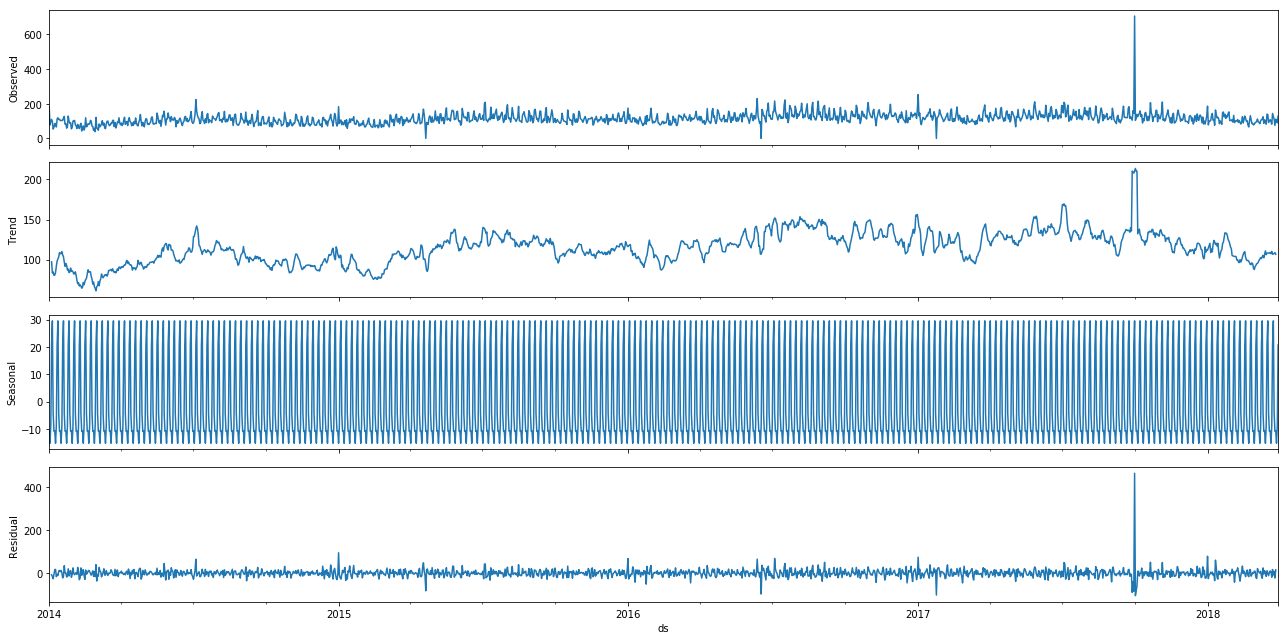

In [12]:
rcParams['figure.figsize'] = 18, 9
fig = decomposition_additive.plot()
plt.show()

In [13]:
# # not working not check where it came from
# rcParams['figure.figsize'] = 18, 9
# fig = decomposition_multiplicative.plot()
# plt.show()

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:19225.882631597102
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:17779.899661585277
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15928.361760228923
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:14867.289842406208
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:15892.821690729648
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:14985.830162233588
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:15455.4114799837
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:14868.558278418346
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:17780.893374469048
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:16976.449900029293
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:15836.178748129416
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:14719.86079339592
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:15785.613371132544
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:15167.749375295276
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:15304.78788639538
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:14720.496083746848
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:15483.965033408527
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:15340.980646982

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2971      0.012     25.148      0.000       0.274       0.320
ma.L1         -1.0000      1.882     -0.531      0.595      -4.689       2.689
ar.S.L12      -0.5065      0.006    -90.815      0.000      -0.517      -0.496
sigma2      1329.8359   2508.165      0.530      0.596   -3586.077    6245.749


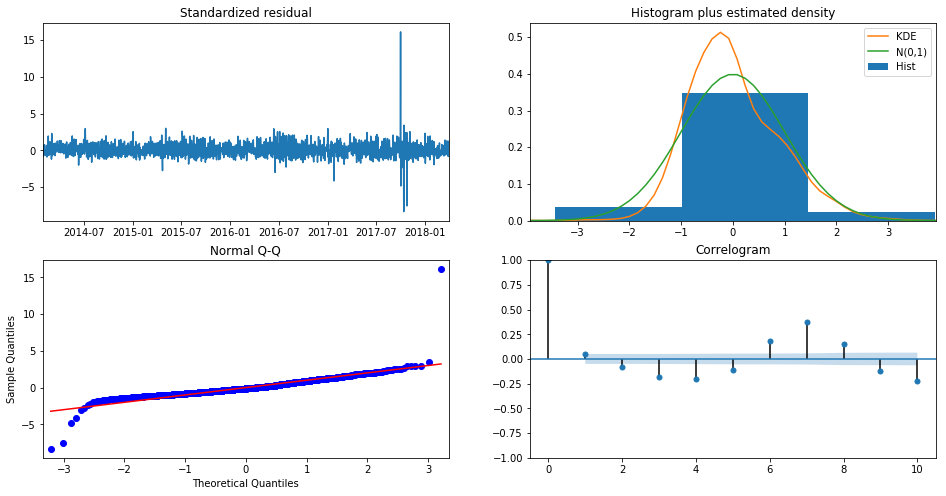

In [17]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

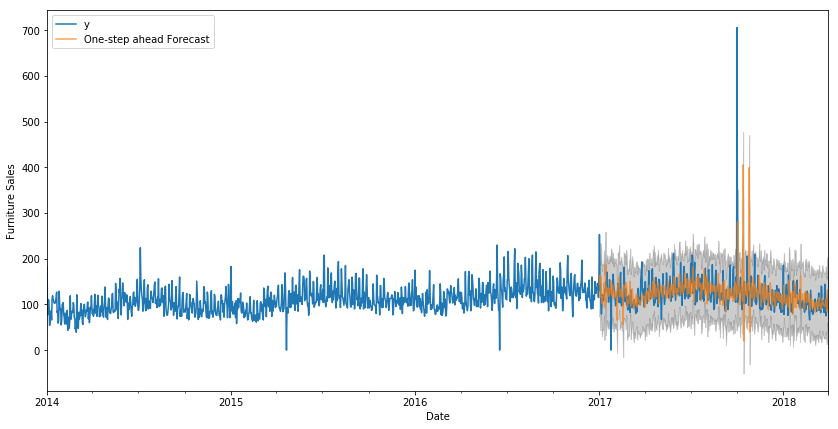

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [19]:
y.head()

y
ds             
2014-01-01  182
2014-01-02   77
2014-01-03   96
2014-01-04  110
2014-01-05   97

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 2017-01-01 00:00:00   nan
2017-01-02 00:00:00   nan
2017-01-03 00:00:00   nan
2017-01-04 00:00:00   nan
2017-01-05 00:00:00   nan
2017-01-06 00:00:00   nan
2017-01-07 00:00:00   nan
2017-01-08 00:00:00   nan
2017-01-09 00:00:00   nan
2017-01-10 00:00:00   nan
2017-01-11 00:00:00   nan
2017-01-12 00:00:00   nan
2017-01-13 00:00:00   nan
2017-01-14 00:00:00   nan
2017-01-15 00:00:00   nan
2017-01-16 00:00:00   nan
2017-01-17 00:00:00   nan
2017-01-18 00:00:00   nan
2017-01-19 00:00:00   nan
2017-01-20 00:00:00   nan
2017-01-21 00:00:00   nan
2017-01-22 00:00:00   nan
2017-01-23 00:00:00   nan
2017-01-24 00:00:00   nan
2017-01-25 00:00:00   nan
2017-01-26 00:00:00   nan
2017-01-27 00:00:00   nan
2017-01-28 00:00:00   nan
2017-01-29 00:00:00   nan
2017-01-30 00:00:00   nan
                       ..
2018-03-03 00:00:00   nan
2018-03-04 00:00:00   nan
2018-03-05 00:00:00   nan
2018-03-06 00:00:00   nan
2018-03-07 00:00:00   nan
2018-03-08 00:00:00  

In [21]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = Prophet(daily_seasonality = False, changepoint_prior_scale = changepoint)
    model.fit(df_date)
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    harmed_forecast[changepoint] = future['yhat']

In [22]:
harmed_forecast.head()

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-01-01  95.71       52.00      112.24        95.71        95.71   
1 2014-01-02  95.72       48.28      110.04        95.72        95.72   
2 2014-01-03  95.74       55.21      116.28        95.74        95.74   
3 2014-01-04  95.75       87.35      144.33        95.75        95.75   
4 2014-01-05  95.76       90.82      152.15        95.76        95.76   

   additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0          -12.22                -12.22                -12.22  -10.41   
1          -17.28                -17.28                -17.28  -15.35   
2          -11.10                -11.10                -11.10   -8.97   
3           18.30                 18.30                 18.30   20.66   
4           26.85                 26.85                 26.85   29.49   

   weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0        -10.41        -10.41   -1.81         -1.81         -1.81   
1        -15.35        -15.35   -1.94         -1.94         -1.94   
2         -8.97         -8.97   -2.13         -2.13         -2.13   
3         20.66         20.66   -2.36         -2.36         -2.36   
4         29.49         29.49   -2.64         -2.64         -2.64   

   multiplicative_terms  multiplicative_terms_lower  \
0                  0.00                        0.00   
1                  0.00                        0.00   
2                  0.00                        0.00   
3                  0.00                        0.00   
4                  0.00                        0.00   

   multiplicative_terms_upper   yhat  0.001   0.05    0.1    0.5  
0                        0.00  83.49  84.71  83.49  84.91  87.72  
1                        0.00  78.44  79.63  78.44  79.83  82.53  
2                        0.00  84.64  85.81  84.64  86.00  88.61  
3                        0.00 114.05 115.19 114.05 115.38 117.89  
4                        0.00 122.61 123.79 122.61 123.91 126.31

In [23]:
harmed_forecast.columns

Index([                        'ds',                      'trend',
                       'yhat_lower',                 'yhat_upper',
                      'trend_lower',                'trend_upper',
                   'additive_terms',       'additive_terms_lower',
             'additive_terms_upper',                     'weekly',
                     'weekly_lower',               'weekly_upper',
                           'yearly',               'yearly_lower',
                     'yearly_upper',       'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper',
                             'yhat',                        0.001,
                               0.05,                          0.1,
                                0.5],
      dtype='object')

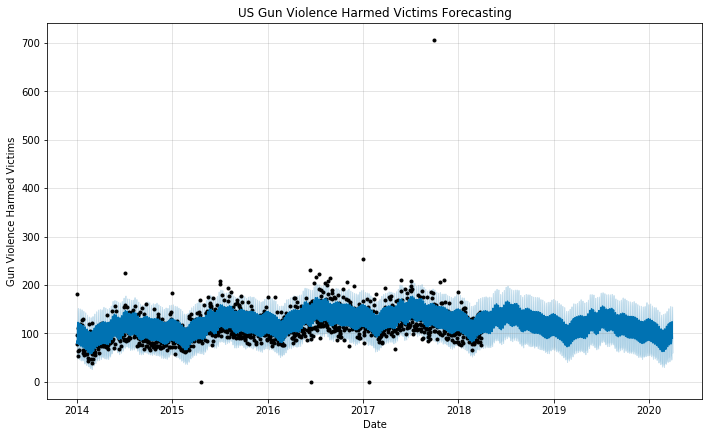

In [24]:
harmed_prophet.plot(harmed_forecast, xlabel = 'Date', ylabel = 'Gun Violence Harmed Victims')
plt.title('US Gun Violence Harmed Victims Forecasting');

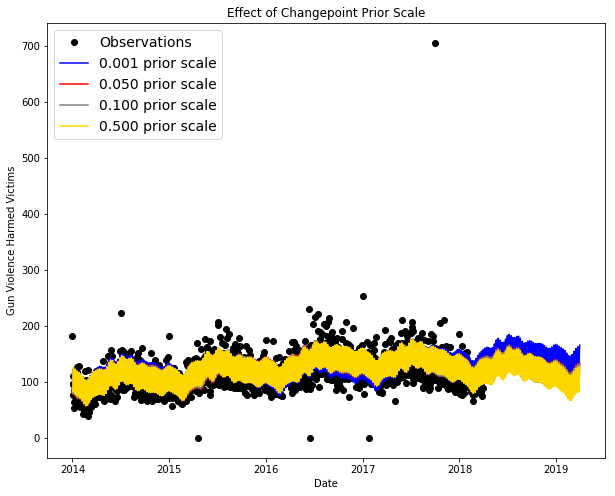

In [25]:
# Create the plot
plt.figure(figsize=(10, 8))
# Actual observations
plt.plot(df_date['ds'], df_date['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(harmed_forecast['ds'], harmed_forecast[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Gun Violence Harmed Victims'); plt.title('Effect of Changepoint Prior Scale');

In [26]:
harmed_prophet.changepoints[:10]

50    2014-02-20
99    2014-04-10
149   2014-05-30
198   2014-07-18
248   2014-09-06
297   2014-10-25
347   2014-12-14
396   2015-02-01
446   2015-03-23
496   2015-05-12
Name: ds, dtype: datetime64[ns]

In [32]:
harmed_forecast

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2014-01-01  95.71       52.00      112.24        95.71        95.71   
1    2014-01-02  95.72       48.28      110.04        95.72        95.72   
2    2014-01-03  95.74       55.21      116.28        95.74        95.74   
3    2014-01-04  95.75       87.35      144.33        95.75        95.75   
4    2014-01-05  95.76       90.82      152.15        95.76        95.76   
5    2014-01-06  95.77       56.04      116.96        95.77        95.77   
6    2014-01-07  95.78       51.85      107.70        95.78        95.78   
7    2014-01-08  95.79       53.36      109.19        95.79        95.79   
8    2014-01-09  95.80       46.65      106.95        95.80        95.80   
9    2014-01-10  95.81       52.34      111.22        95.81        95.81   
10   2014-01-11  95.82       81.74      140.75        95.82        95.82   
11   2014-01-12  95.84       91.39      151.34        95.84        95.84   
12   2014-01-13  95.85       55.32      116.28        95.85        95.85   
13   2014-01-14  95.86       48.05      109.06        95.86        95.86   
14   2014-01-15  95.87       48.11      107.98        95.87        95.87   
15   2014-01-16  95.88       43.92      103.65        95.88        95.88   
16   2014-01-17  95.89       49.71      109.58        95.89        95.89   
17   2014-01-18  95.90       80.90      137.72        95.90        95.90   
18   2014-01-19  95.91       88.40      149.52        95.91        95.91   
19   2014-01-20  95.93       52.43      112.73        95.93        95.93   
20   2014-01-21  95.94       46.53      105.21        95.94        95.94   
21   2014-01-22  95.95       45.51      106.18        95.95        95.95   
22   2014-01-23  95.96       44.00      102.06        95.96        95.96   
23   2014-01-24  95.97       46.62      106.95        95.97        95.97   
24   2014-01-25  95.98       79.05      137.51        95.98        95.98   
25   2014-01-26  95.99       84.93      146.15        95.99        95.99   
26   2014-01-27  96.00       51.39      115.19        96.00        96.00   
27   2014-01-28  96.01       45.26      106.41        96.01        96.01   
28   2014-01-29  96.03       46.68      104.89        96.03        96.03   
29   2014-01-30  96.04       37.49       97.43        96.04        96.04   
...         ...    ...         ...         ...          ...          ...   
2251 2020-03-01 100.75       78.15      141.39        91.58       110.27   
2252 2020-03-02 100.72       43.69      104.98        91.52       110.25   
2253 2020-03-03 100.69       38.44       99.66        91.46       110.24   
2254 2020-03-04 100.67       38.58      102.30        91.40       110.23   
2255 2020-03-05 100.64       37.07       98.97        91.35       110.22   
2256 2020-03-06 100.61       43.25      107.41        91.30       110.21   
2257 2020-03-07 100.58       73.95      135.44        91.24       110.20   
2258 2020-03-08 100.55       85.33      146.10        91.19       110.19   
2259 2020-03-09 100.53       48.44      112.17        91.13       110.18   
2260 2020-03-10 100.50       44.13      106.40        91.08       110.17   
2261 2020-03-11 100.47       43.94      107.32        91.02       110.16   
2262 2020-03-12 100.44       40.93      104.06        90.97       110.15   
2263 2020-03-13 100.42       48.99      111.67        90.91       110.14   
2264 2020-03-14 100.39       79.57      140.18        90.86       110.13   
2265 2020-03-15 100.36       86.21      151.85        90.82       110.12   
2266 2020-03-16 100.33       53.46      118.18        90.78       110.11   
2267 2020-03-17 100.31       49.99      111.57        90.75       110.13   
2268 2020-03-18 100.28       50.96      112.53        90.71       110.15   
2269 2020-03-19 100.25       42.36      106.87        90.68       110.16   
2270 2020-03-20 100.22       50.67      115.60        90.64       110.18   
2271 2020-03-21 100.19       79.95      143.58        90.61  

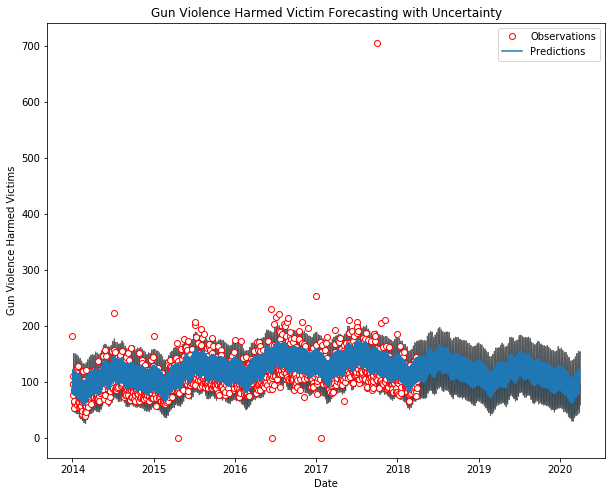

In [27]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Plot observations
ax.plot(df_date['ds'], df_date['y'], 'ko', label = 'Observations', color = 'white', markeredgecolor ='red')
# Plot estimate
ax.plot(harmed_forecast['ds'], harmed_forecast['yhat'], label = 'Predictions')
# # Plot uncertainty values
ax.fill_between(harmed_forecast['ds'].dt.to_pydatetime(), harmed_forecast['yhat_upper'], harmed_forecast['yhat_lower'], alpha=0.6, edgecolor = 'k')
plt.xlabel('Date')
plt.ylabel('Gun Violence Harmed Victims')
plt.title('Gun Violence Harmed Victim Forecasting with Uncertainty')
plt.legend();

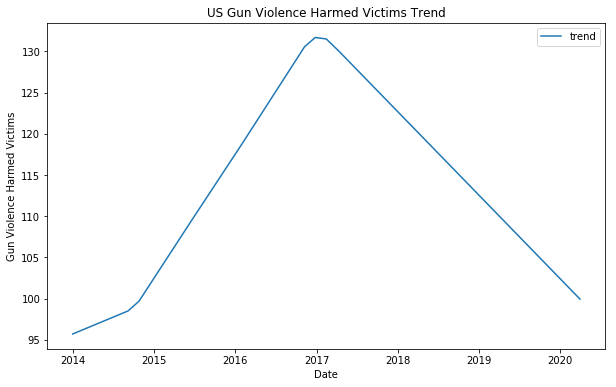

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(harmed_forecast['ds'], harmed_forecast['trend'])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Gun Violence Harmed Victims')
plt.title('US Gun Violence Harmed Victims Trend');

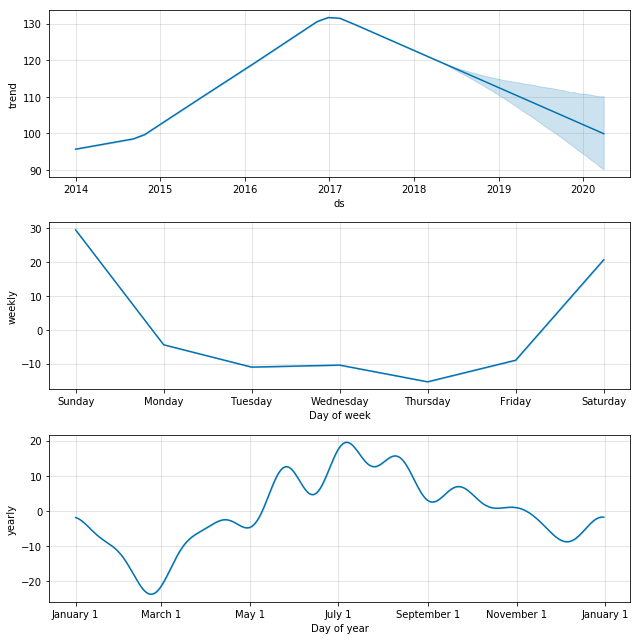

In [29]:
harmed_prophet.plot_components(harmed_forecast);

In [30]:
# num_incidents_df = pd.read_pickle('Pickles/df_date_2.pkl')
# num_incidents_df = num_incidents_df[['date', 'num_incidents']]

# # exporting harmed_forecast trend to assets repository for d3.js visualization
# num_incidents_df.rename({'ds': 'date'}, axis = 1, inplace = True)
# harmed_forecast.rename({'ds': 'date'}, axis = 1, inplace = True)
# df_date.rename({'ds': 'date', 'y': 'num_harmed'}, axis = 1, inplace = True)
# d3_data = pd.merge(harmed_forecast, df_date, on = 'date', how='outer')
# d3_data = pd.merge(d3_data, num_incidents_df, on = 'date', how='left')
# d3_data = d3_data.reset_index()

# d3_data.loc[d3_data['index']>=d3_data[d3_data['date']==d3_data[d3_data['num_harmed'].isnull()]['date'].min()].index.values[0], 'non_observation'] = 1
# d3_data['year'] = d3_data['date'].dt.year

# d3_data.loc[(d3_data['date'].dt.day==1) & (d3_data['date'].dt.month==1), 'nyd'] = 1
# for i, new_years in enumerate(list(d3_data[d3_data['nyd']==1].index.values)):
#     d3_data.loc[new_years, 'nyd'] = i
    
# d3_data = d3_data[['index', 'date', 'trend', 'num_harmed', 'non_observation', 'year', 'nyd', 'num_incidents']]
# d3_data.to_csv('../cyaris.github.io/assets/us_harmed_victim_forecast_data.csv')

In [31]:
# d3_data.head()